In [1]:
from cloudvolume import CloudVolume
from skimage.transform import downscale_local_mean
import napari
from skimage import io
import random
import h5py
from skimage import measure
from brainlit.preprocessing import removeSmallCCs
import numpy as np 
import matplotlib.pyplot as plt 
import subprocess
import tables
from napari_animation import AnimationWidget
from tqdm import tqdm
import pickle
from parse_ara import *
import networkx as nx
import seaborn as sns
import pandas as pd
import brainrender
import scipy.ndimage as ndi
%gui qt5

/Users/thomasathey/Documents/mimlab/mouselight/docs_env/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


embedWindow(verbose=True): could not load ipyvtk_simple try:
> pip install -U git+https://github.com/Kitware/ipyvtk-simple.git


# Download benchmark data

In [ ]:

dir = "precomputed://https://dlab-colm.neurodata.io/2021_04_08/gad2cre_tph2flp_con_fon_8291/561"
mip = 0

vol_bg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
shape = vol_bg.shape
print(shape)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_04_08/gad2cre_tph2flp_con_fon_8291/642"
mip = 0

vol_fg = CloudVolume(dir)
shape = vol_fg.shape
print(shape)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_04_08/gad2cre_tph2flp_con_fon_8291/axon_mask"
dir = "s3://smartspim-precomputed-volumes/2021_04_08/gad2cre_tph2flp_con_fon_8291/axon_mask"
mip = 0

vol_mask = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
shape = vol_mask.shape
print(shape)


In [ ]:
centers_train = [[2477, 3638, 2409], [3605, 2873, 2405], [4939, 5186, 2398], [4538, 5148, 2398], [4618, 3225, 2388], [3223, 5206, 3550], [1953, 2102, 3577], [2395, 5004, 3584], [941, 3711, 708], [2030, 2164, 701], [3283, 3406, 1255], [1531, 2220, 1242], [2569, 6420, 2924], [2282, 8206, 2924], [4424, 5689, 2896], [3269, 3987, 2896], [2817, 6831, 4565], [3308, 3276, 4124], [4560, 6354, 4133], [4293, 2411, 2297], [5254, 5429, 2877], [3851, 2185, 2877], [2261, 8272, 2877], [3970, 3496, 2877], [1277, 2284, 2877]]
centers_val = [[5701, 3357, 4137], [3610, 2346, 4137], [2564, 4086, 2829], [1282, 2182, 2829], [3960, 2836, 1546], [2347, 4866, 1545], [1680, 4284, 806], [3223, 3294, 2514], [3564, 3847, 2516], [2620, 7237, 4610]]

In [ ]:
for i, center in enumerate(centers_train):
    if i < 20:
        continue
    image_fg = vol_fg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_fg = image_fg[:,:,:,0]

    image_bg = vol_bg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_bg = image_bg[:,:,:,0]
    image_2channel = np.stack([image_bg, image_fg], axis=0)
    
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/train_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)
    

## View data

In [ ]:
center = centers_train[23]

image_fg = vol_fg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
image_fg = image_fg[:,:,:,0]

image_bg = vol_bg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
image_bg = image_bg[:,:,:,0]

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg)
viewer.add_image(image_bg)

## Check training results

In [ ]:
true_pos_total = 0
false_pos_total = 0
true_labels_total = 0

for i in range(20):
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/train_" + str(i) + ".h5"
    f = h5py.File(fname, 'r')
    im = f.get('image_2channel')
    im_bg = im[0,:,:,:]
    im_fg = im[1,:,:,:]

    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/train_" + str(i) + "-image_2channel_Labels.h5"
    f = h5py.File(fname, 'r')
    gt = f.get('exported_data')
    gt = gt[0,:,:,:]
    pos_labels = gt == 2
    num_pos_labels = np.sum(pos_labels)

    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/train_" + str(i) + "-image_2channel_Probabilities.h5"
    f = h5py.File(fname, 'r')
    seg = f.get('exported_data')
    seg = seg[1,:,:,:]
    mask = seg > 0.5

    true_pos = np.sum(np.logical_and(mask, pos_labels))
    true_pos_total += true_pos
    false_pos = np.sum(np.logical_and(mask, gt == 1))
    false_pos_total += false_pos
    true_labels = np.sum(pos_labels)
    true_labels_total += true_labels
    
    if num_pos_labels > 0:
        precision = true_pos/(true_pos + false_pos)
        recall = true_pos/true_labels
        print(f"Example {i}: precision: {precision}, recall: {recall}")
    else:
        print(f"Example {i}: 0 positive labels, false positive rate is: {false_pos/np.sum(gt == 1)}")

    '''
    viewer = napari.Viewer(ndisplay=3)
    viewer.add_image(im_bg)
    viewer.add_image(im_fg)
    viewer.add_labels(gt)
    viewer.add_labels(mask)
    '''
print(f"Total precision: {true_pos_total/(true_pos_total + false_pos_total)} total recall: {true_pos_total/true_labels_total} with {true_labels_total} total positive voxels")

## Check Val results

In [ ]:
true_pos_total = 0
false_pos_total = 0
true_labels_total = 0
spacing =  0.02
thresholds = np.arange(spacing, 1.0, spacing)
precisions = []
recalls = []
best_fscore = 0

for threshold in thresholds:
    for i in range(10):
        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/val_" + str(i) + ".h5"
        f = h5py.File(fname, 'r')
        im = f.get('image_2channel')
        im_bg = im[0,:,:,:]
        im_fg = im[1,:,:,:]

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/val_" + str(i) + "-image_2channel_Labels.h5"
        f = h5py.File(fname, 'r')
        gt = f.get('exported_data')
        gt = gt[0,:,:,:]
        pos_labels = gt == 2
        num_pos_labels = np.sum(pos_labels)

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/val_" + str(i) + "_Probabilities.h5"
        f = h5py.File(fname, 'r')
        seg = f.get('exported_data')
        seg = seg[1,:,:,:]
        mask = seg > threshold

        true_pos = np.sum(np.logical_and(mask, pos_labels))
        true_pos_total += true_pos
        false_pos = np.sum(np.logical_and(mask, gt == 1))
        false_pos_total += false_pos
        true_labels = np.sum(pos_labels)
        true_labels_total += true_labels
        
        if num_pos_labels > 0:
            precision = true_pos/(true_pos + false_pos)
            recall = true_pos/true_labels
            #print(f"Example {i}: precision: {precision}, recall: {recall}")
        else:
            #print(f"Example {i}: 0 positive labels, false positive rate is: {false_pos/np.sum(gt == 1)}")
            pass
        '''
        viewer = napari.Viewer(ndisplay=3)
        viewer.add_image(im_bg)
        viewer.add_image(im_fg)
        viewer.add_labels(gt)
        viewer.add_labels(mask)
        '''
    precision_total = true_pos_total/(true_pos_total + false_pos_total)
    recall_total = true_pos_total/true_labels_total
    fscore = 2/(1/precision_total+1/recall_total)
    print(f"Thresh: {threshold:.2f} --- Total prec.: {precision_total:.3f} total rec.: {recall_total:.3f} w/{true_labels_total} total pos voxels. F-score: {fscore:.4f}")
    if fscore > best_fscore:
        best_fscore = fscore
        best_prec = precision_total
        best_recall = recall_total
    precisions.append(precision_total) 
    recalls.append(recall_total)
plt.plot(recalls, precisions, label='Prec-Rec Curve')
plt.scatter([best_recall], [best_prec], c='red', label=f"Best F-score: {best_fscore:.4f}")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Validation Performance Brain1')
plt.legend()

## Brain 2 

In [ ]:
dir = "precomputed://https://dlab-colm.neurodata.io/2021_06_02_Sert_Cre/Ch_647"
mip = 0

vol_fg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
shape = vol_fg.shape
print(shape)

centers_val = [[2626,3837,2366],[799,3315,2366],[3851,5443,2346],[3260,5490,2351],[3198,7658,2351],[2998,4502,1215],[4269,1657,1215],[3071,1153,3412],[3672,1792,409],[2235,4195,409]]

In [ ]:
# download data
for i, center in enumerate(centers_val):
    image_fg = vol_fg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_fg = image_fg[:,:,:,0]

    image_bg = 0*image_fg
    image_2channel = np.stack([image_bg, image_fg], axis=0)
    
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain2/val_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)
    

In [ ]:
true_pos_total = 0
false_pos_total = 0
true_labels_total = 0
thresholds = np.arange(0.1,1.0,0.02)
precisions = []
recalls = []
best_fscore = 0

for threshold in thresholds:
    for i in range(10):
        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain2/val_" + str(i) + ".h5"
        f = h5py.File(fname, 'r')
        im = f.get('image_2channel')
        im_bg = im[0,:,:,:]
        im_fg = im[1,:,:,:]

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain2/val_" + str(i) + "-image_2channel_Labels.h5"
        f = h5py.File(fname, 'r')
        gt = f.get('exported_data')
        gt = gt[0,:,:,:]
        pos_labels = gt == 2
        num_pos_labels = np.sum(pos_labels)

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain2/val_" + str(i) + "_Probabilities.h5"
        f = h5py.File(fname, 'r')
        seg = f.get('exported_data')
        seg = seg[1,:,:,:]
        mask = seg > threshold

        true_pos = np.sum(np.logical_and(mask, pos_labels))
        true_pos_total += true_pos
        false_pos = np.sum(np.logical_and(mask, gt == 1))
        false_pos_total += false_pos
        true_labels = np.sum(pos_labels)
        true_labels_total += true_labels
        
        if num_pos_labels > 0:
            precision = true_pos/(true_pos + false_pos)
            recall = true_pos/true_labels
            #print(f"Example {i}: precision: {precision}, recall: {recall}")
        else:
            #print(f"Example {i}: 0 positive labels, false positive rate is: {false_pos/np.sum(gt == 1)}")
            pass

        '''
        viewer = napari.Viewer(ndisplay=3)
        viewer.add_image(im_bg)
        viewer.add_image(im_fg)
        viewer.add_labels(gt)
        viewer.add_labels(mask)
        napari.run()
        '''
        
    precision_total = true_pos_total/(true_pos_total + false_pos_total)
    recall_total = true_pos_total/true_labels_total
    fscore = 2/(1/precision_total+1/recall_total)
    print(f"Threshold: {threshold} ----- Total precision: {precision_total} total recall: {recall_total} with {true_labels_total} total positive voxels. F-score: {fscore}")
    if fscore > best_fscore:
        best_fscore = fscore
        best_prec = precision_total
        best_recall = recall_total
    precisions.append(precision_total) 
    recalls.append(recall_total)


plt.plot(recalls, precisions, label='Prec-Rec Curve')
plt.scatter([best_recall], [best_prec], c='red', label=f"Best F-score: {best_fscore}")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Validation Performance Brain 2')
plt.legend()

## Check whole brain results

In [ ]:
#download from cloud
centers = [[2304, 3840, 2100], [2560, 3840, 1800]]

for i,center in enumerate(centers):
    image_fg = vol_fg[center[0]:center[0]+256,center[1]:center[1]+256, center[2]:center[2]+300]
    image_fg = image_fg[:,:,:,0]

    image_bg = vol_bg[center[0]:center[0]+256,center[1]:center[1]+256, center[2]:center[2]+300]
    image_bg = image_bg[:,:,:,0]

    mask_s3 = vol_mask[center[0]:center[0]+256,center[1]:center[1]+256, center[2]:center[2]+300]
    mask_s3 = mask_s3[:,:,:,0]

    image_2channel = np.stack([image_bg, image_fg], axis=0)
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/test_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)

    

In [ ]:
#read ilastik output
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/test_1_Probabilities.h5"
f = h5py.File(fname, 'r')
im = f.get('exported_data')
pred = im[1,:,:,:]
mask = pred > 0.32

In [ ]:
#read cis file
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_1800.h5"
f = h5py.File(fname, 'r')
im = f.get('image_2channel')
image_fg_cis = im[1,:,:,:,0]
image_bg_cis = im[0,:,:,:,0]

#read cis file
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_1800_Probabilities.h5"
f = h5py.File(fname, 'r')
ks = list(f.keys())
pred = f[ks[0]]
pred_cis = pred[1,:,:,:]
pred_cis = np.squeeze(pred_cis)
mask_cis = pred_cis > 0.32

In [ ]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_fg)
viewer.add_image(image_bg)
viewer.add_labels(mask_s3)
viewer.add_labels(mask)
viewer.add_image(image_fg_cis)
viewer.add_image(image_bg_cis)
viewer.add_labels(mask_cis)
napari.run()

In [ ]:
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_0.h5"

subprocess.run(["/Applications/ilastik-1.3.3post3-OSX.app/Contents/ilastik-release/run_ilastik.sh",  "--headless", "--project=/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/matt_benchmark_formal.ilp", fname], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Brain 3

In [ ]:
dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/Ch_647"
mip = 0
vol_fg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/Ch_561"
vol_bg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/Ch_488"
vol_endo = CloudVolume(dir, parallel=1, mip=0, fill_missing=True)
print(vol_endo.shape)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/axon_mask"
vol_mask = CloudVolume(dir, parallel=1, mip=0, fill_missing=False)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/atlas_to_target"
vol_reg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

centers_train = [[3007, 4546, 2697], [4466, 4467, 2697], [2670, 606, 2700], [1135, 751, 2700], [2354, 793, 1686], [327, 3241, 1686], [3961, 5206, 1686], [2852, 5223, 1686], [3574, 5145, 3261], [3566, 1245, 1399],
                [836, 2652, 1399], [2232, 6470, 1399], [2274, 3788, 2248], [2286, 1678, 2248], [4215, 1992, 2248], [2974, 2556, 2711], [2133, 2004, 2711], [3942, 5743, 2711], [2600, 5259, 485], [3090, 3676, 485],
                [1341, 5648, 2227], [1013, 4294, 2227], [3341, 3992, 2227], [1772, 5628, 3011], [1039, 5685, 1038], [2170, 3928, 1861], [3040, 3047, 1861]]
centers_val = [[2639, 513, 2432], [4592, 4209, 2432], [4234, 4105, 3331], [2067, 4007, 1683], [4764, 2569, 1683], [2579, 2759, 583], [3244, 3921, 575], [2298, 1555, 575], [3081, 4587, 2971], [3402, 6232, 2697],
                [4426, 4334, 1038], [857, 2867, 1038], [1665, 5523, 2391], [2027, 4258, 1861]]

## Download 3 channel data

In [ ]:
# download data
for i, center in enumerate(centers_val):
    if i < 0:
        continue
    image_fg = vol_fg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_fg = image_fg[:,:,:,0]

    image_bg = vol_bg[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_bg = image_bg[:,:,:,0]

    image_endo = vol_endo[center[0]-49:center[0]+50,center[1]-49:center[1]+50, center[2]-49:center[2]+50]
    image_endo = image_endo[:,:,:,0]

    image_2channel = np.stack([image_bg, image_fg, image_endo], axis=0)
    
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain4/val_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)

## View 3 channel data

In [ ]:
#view volumes
i = 6
set = "val"
brain = 4

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain" + str(brain) + "/" + set + "_" + str(i) + ".h5"
with h5py.File(fname, 'r') as f:
    ks = list(f.keys())
    im = f[ks[0]]
    image_bg = im[0,:,:,:]
    image_fg = im[1,:,:,:]
    image_endo = im[2,:,:,:]
    print(im.shape)

viewer = napari.Viewer(ndisplay=3)
animation_widget = AnimationWidget(viewer)
viewer.window.add_dock_widget(animation_widget, area='right')
viewer.add_image(image_bg)
viewer.add_image(image_endo)
viewer.add_image(image_fg)
napari.run()  

In [ ]:

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_0.h5"
with h5py.File(fname, 'r') as f:
    ks = list(f.keys())
    im = f[ks[0]]
    image_bg = im[0,:,:,:,0]
    image_fg = im[1,:,:,:,0]
    image_endo = im[2,:,:,:,0]
    print(im.shape)

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/image_0_Probabilities.h5"
with h5py.File(fname, 'r') as f:
    ks = list(f.keys())
    im = f[ks[0]]
    probs = im[1,:,:,:,0]
    print(im.shape)

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image_bg)
viewer.add_image(image_endo)
viewer.add_image(image_fg)
viewer.add_image(probs)
napari.run()  

## Compute precision recall

In [ ]:
brain = 4

true_pos_total = 0
false_pos_total = 0
true_labels_total = 0
thresholds = np.arange(0.1,1.0,0.02)
precisions = []
recalls = []
best_fscore = 0

for threshold in thresholds:
    for i in range(7):
        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain" + str(brain) + "/val_" + str(i) + ".h5"
        f = h5py.File(fname, 'r')
        im = f.get('image_2channel')
        im_bg = im[0,:,:,:]
        im_fg = im[1,:,:,:]

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain" + str(brain) + "/val_" + str(i) + "-image_2channel_Labels.h5"
        f = h5py.File(fname, 'r')
        gt = f.get('exported_data')
        gt = gt[0,:,:,:]
        pos_labels = gt == 2
        num_pos_labels = np.sum(pos_labels)

        fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain" + str(brain) + "/val_" + str(i) + "_Probabilities.h5"
        f = h5py.File(fname, 'r')
        seg = f.get('exported_data')
        seg = seg[1,:,:,:]
        mask = seg > threshold

        true_pos = np.sum(np.logical_and(mask, pos_labels))
        true_pos_total += true_pos
        false_pos = np.sum(np.logical_and(mask, gt == 1))
        false_pos_total += false_pos
        true_labels = np.sum(pos_labels)
        true_labels_total += true_labels
        
        if num_pos_labels > 0:
            precision = true_pos/(true_pos + false_pos)
            recall = true_pos/true_labels
            #print(f"Example {i}: precision: {precision}, recall: {recall}")
        else:
            #print(f"Example {i}: 0 positive labels, false positive rate is: {false_pos/np.sum(gt == 1)}")
            pass

        '''
        viewer = napari.Viewer(ndisplay=3)
        viewer.add_image(im_bg)
        viewer.add_image(im_fg)
        viewer.add_labels(gt)
        viewer.add_labels(mask)
        napari.run()
        '''
        
    precision_total = true_pos_total/(true_pos_total + false_pos_total)
    recall_total = true_pos_total/true_labels_total
    fscore = 2/(1/precision_total+1/recall_total)
    print(f"Threshold: {threshold} ----- Total precision: {precision_total} total recall: {recall_total} with {true_labels_total} total positive voxels. F-score: {fscore}")
    if fscore > best_fscore:
        best_fscore = fscore
        best_prec = precision_total
        best_recall = recall_total
    precisions.append(precision_total) 
    recalls.append(recall_total)


plt.plot(recalls, precisions, label='Prec-Rec Curve')
plt.scatter([best_recall], [best_prec], c='red', label=f"Best F-score: {best_fscore}")
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title(f'Validation Performance Brain ' + str(brain))
plt.legend()

## Downsample

In [ ]:
tasks = create_downsampling_tasks(
    layer_path, # e.g. 'gs://bucket/dataset/layer'
    mip=0, # Start downsampling from this mip level (writes to next level up)
    fill_missing=True, # Ignore missing chunks and fill them with black
    axis='z', 
    num_mips=5, # number of downsamples to produce. Downloaded shape is chunk_size * 2^num_mip
    chunk_size=None, # manually set chunk size of next scales, overrides preserve_chunk_size
    preserve_chunk_size=True, # use existing chunk size, don't halve to get more downsamples
    sparse=False, # for sparse segmentation, allow inflation of pixels against background
    bounds=None, # mip 0 bounding box to downsample 
    encoding=None, # e.g. 'raw', 'compressed_segmentation', etc
    delete_black_uploads=False, # issue a delete instead of uploading files containing all background
    background_color=0, # Designates the background color
    compress='gzip', # None, 'gzip', and 'br' (brotli) are options
    factor=(2,2,2), # common options are (2,2,1) and (2,2,2)
  )


In [ ]:
dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/axon_mask"
vol_mask_ds = CloudVolume(dir, parallel=1, mip=3, fill_missing=False)
print(vol_mask_ds.shape)

data = vol_mask_ds[:,:,:,:]
data = np.squeeze(data).T
io.imsave("/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain3/register/axon_mask_3.tif", data)
#data = data[:,:,:,0]

# viewer = napari.Viewer(ndisplay=3)
# viewer.add_image(ds[:,:,:,0])
# napari.run() 

## Registration

In [ ]:
img = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain3/register/axon_mask_3.tif"
og = io.imread(img)
print(og.shape)

In [ ]:
im_path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain3/register/registered_3.img"
im = io.imread(im_path)
print(im.shape)

In [ ]:
viewer = napari.Viewer(ndisplay=3)
animation_widget = AnimationWidget(viewer)
viewer.window.add_dock_widget(animation_widget, area='right')
viewer.add_image(image_rescaled2)
viewer.add_image(image_rescaled)
#viewer.add_image(im)
#viewer.add_image(og)
napari.run() 

In [ ]:
image_rescaled2 = image_rescaled.copy()
image_rescaled2 = ndi.gaussian_filter(image_rescaled2, sigma = 3)

In [ ]:
from skimage.transform import rescale, resize, downscale_local_mean
image_rescaled = rescale(im, 1/2.5, anti_aliasing=False)
image_rescaled = image_rescaled.T
print(image_rescaled.shape)

In [ ]:
np.save("/Users/thomasathey/Documents/mimlab/mouselight/ailey/wholebrain_results/brain3/register/registered_3_ds_smoothed.npy", image_rescaled2)

## Atlas readout

In [ ]:
volumes = {}
for x in tqdm(np.arange(0, vol_mask.shape[0], 128)):
    x2 = np.amin([x+128, vol_mask.shape[0]])
    for y in tqdm(np.arange(0, vol_mask.shape[1], 128), leave=False):
        y2 = np.amin([x+128, vol_mask.shape[1]])
        for z in tqdm(np.arange(0, vol_mask.shape[1], 128), leave=False):
            z2 = np.amin([x+128, vol_mask.shape[2]])
            labels = vol_reg[x:x2,y:y2,z:z2]
            labels_unique = np.unique(labels)
            mask = vol_mask[x:x2,y:y2,z:z2]

            for unq in labels_unique:
                if unq in volumes.keys():
                    cur_vol = volumes[unq]
                else:
                    cur_vol = 0
                cur_vol += np.sum(mask[labels == unq])
                volumes[unq] = cur_vol

## Read quantification dictionary

In [2]:
path = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/benchmark_formal/brain3/quantification.pkl"
#with open(path, "rb") as f:
#    quantification_dict = pickle.load(f)
quantification_dict = {97:  133348. , 836:  145216. , 540:  179159. , 1121:  1171931. , 959:  71186. , 427:  433264. , 1127:  207365. , 1041:  1505367. , 526:  1054137. , 20:  1865723. , 543:  1027011. , 32767:  9241493. , 52:  1188841. , 139:  1432394. , 234:  225380. , 289:  510119. , 988:  303761. , 335:  53907. , 692:  169561. , 729:  364305. , 888:  377159. , 977:  327138. , 28:  975675. , 643:  6994. , 696:  18365. , 735:  51567. , 755:  127985. , 759:  1151. , 791:  84526. , 816:  124911. , 847:  412400. , 990:  191453. , 1023:  488036. , 520:  241410. , 566:  2144579. , 251:  120709. , 961:  9071479. , 527:  93384. , 600:  87327. , 806:  689157. , 873:  495800. , 1035:  399283. , 897:  202442. , 1010:  56847. , 1106:  272001. , 120:  204740. , 163:  607143. , 1064:  2517727. , 1025:  2599631. , 1056:  3617566. , 728:  4013522. , 843:  697944. , 664:  716836. , 727:  463284. , 1089:  321995. , 466:  360238. , 502:  1055769. , 579:  616117. , 786:  67759. , 382:  5922358. , 249:  23856. , 456:  20363. , 598:  30282. , 954:  210105. , 971:  417729. , 1005:  42866. , 952:  1583345. , 698:  2767600. , 1074:  28667. , 81:  153342. , 1045:  25351. , 997:  717871. , 252:  231365. , 678:  61558. , 884:  110624. , 964:  86599. , 703:  275556. , 1090:  1086573. , 862:  983516. , 857:  305357. , 1058:  223362. , 314:  469993. , 344:  833670. , 558:  203311. , 148:  63978. , 180:  210819. , 187:  313732. , 36:  83104. , 878:  456077. , 1033:  1683751. , 1049:  719552. , 1007:  3625793. , 750:  128553. , 269:  122265. , 421:  68363. , 573:  38990. , 593:  433960. , 613:  91283. , 821:  346563. , 869:  8090. , 973:  78790. , 377:  61243. , 393:  4764. , 743:  462483. , 902:  82431. , 74:  48956. , 121:  7093. , 10703:  2109541. , 966:  800086. , 655:  933948. , 423:  151705. , 311:  881013. , 233:  70523. , 905:  56536. , 1114:  3661. , 156:  53189. , 243:  21035. , 601:  24495. , 649:  225. , 463:  2076904. , 131:  515565. , 334:  764939. , 788:  1057245. , 201:  366365. , 981:  387284. , 1047:  401022. , 893:  142505. , 986:  114328. , 672:  8864336. , 451:  313925. , 1070:  444039. , 355:  3901. , 477:  2140847. , 303:  842669. , 849:  29057. , 583:  843002. , 838:  234301. , 654:  313703. , 702:  222475. , 638:  345068. , 662:  60710. , 950:  773616. , 974:  1287440. , 657:  747072. , 328:  965065. , 1101:  1166542. , 694:  348010. , 996:  311535. , 704:  86518. , 512:  275531. , 354:  2470471. , 794:  432325. , 108:  300842. , 153:  93234. , 1123:  191941. , 96:  434539. , 846:  315707. , 101:  416836. , 1091:  4614863. , 33:  288701. , 721:  268035. , 778:  573819. , 1037:  497940. , 1084:  270824. , 443:  248959. , 632:  300424. , 10704:  161742. , 663:  563980. , 780:  1665587. , 305:  37059. , 1009:  306852. , 1038:  436160. , 1062:  65449. , 603:  410423. , 301:  117424. , 544:  290034. , 551:  82660. , 559:  615862. , 327:  480973. , 6:  510280. , 1022:  771312. , 1105:  88438. , 639:  664281. , 889:  383664. , 929:  33917. , 665:  423238. , 2:  106838. , 1102:  1210518. , 675:  120269. , 783:  582290. , 800:  571875. , 320:  941288. , 943:  1993417. , 429:  3584674. , 437:  2262948. , 553:  1232. , 91:  625683. , 445:  1132067. , 413:  81142. , 78:  107017. , 771:  1617806. , 7:  1144087. , 671:  284208. , 965:  230781. , 442:  384112. , 229:  27467. , 274:  196037. , 610:  284422. , 774:  159262. , 906:  107826. , 313:  4197306. , 1072:  146405. , 1079:  90686. , 549:  432322. , 66:  36. , 1044:  16829. , 1088:  197154. , 924:  69173. , 27:  115667. , 916:  66569. , 178:  380740. , 797:  1215702. , 125:  99609. , 321:  1349. , 262:  523307. , 718:  305386. , 1092:  15816. , 403:  742988. , 803:  477914. , 1031:  140185. , 342:  1641651. , 998:  318975. , 23:  282007. , 1139:  26562. , 908:  62979. , 754:  2397389. , 450:  276700. , 854:  487511. , 577:  286862. , 882:  124212. , 1108:  224169. , 831:  73185. , 648:  2376635. , 844:  1814577. , 656:  1436813. , 957:  2033932. , 1098:  1794708. , 903:  80169. , 136:  1877585. , 863:  236000. , 955:  60792. , 866:  53592. , 968:  625568. , 852:  2844254. , 978:  255883. , 225:  574745. , 765:  22967. , 651:  1270541. , 203:  56020. , 963:  2181. , 217:  326650. , 209:  372318. , 506:  8883. , 661:  465408. , 984:  2019423. , 326:  395251. , 781:  354. , 202:  1724359. , 482:  72861. , 828:  1619463. , 123:  412696. , 850:  86562. , 867:  984488. , 621:  193160. , 798:  18433. , 612:  472287. , 616:  208898. , 658:  577013. , 534:  215941. , 93:  5447. , 434:  233747. , 128:  3894844. , 271:  34705. , 874:  2548. , 10:  1198782. , 580:  53129. , 1029:  81518. , 381:  330875. , 75:  319. , 218:  524732. , 325:  129028. , 374:  63243. , 470:  34869. , 1097:  1519279. , 41:  59484. , 401:  60925. , 501:  18671. , 1066:  120662. , 733:  842499. , 1020:  656180. , 349:  414. , 670:  183295. , 9:  104202. , 461:  8348. , 1111:  197841. , 155:  195861. , 194:  1452864. , 292:  25577. , 1006:  142908. , 625:  477427. , 1086:  39628. , 945:  391791. , 268:  24541. , 260:  130059. , 1026:  45016. , 98:  6172. , 298:  263129. , 56:  1851319. , 956:  180692. , 699:  2738. , 767:  2892589. , 1021:  1410871. , 962:  2261648. , 951:  971547. , 380:  68195. , 711:  558071. , 1107:  548527. , 936:  1514702. , 944:  536293. , 859:  144653. , 145:  220995. , 989:  253687. , 372:  40518. , 106:  19693. , 811:  1873306. , 1093:  317095. , 105:  75381. , 114:  285713. , 122:  259355. , 841:  23323. , 820:  1133655. , 1052:  397040. , 146:  322356. , 834:  85258. , 842:  267774. , 851:  188021. , 17:  1865989. , 26:  579537. , 246:  113245. , 931:  133349. , 430:  494041. , 542:  164963. , 687:  795311. , 832:  841. , 805:  53798. , 257:  30331. , 469:  1160. , 565:  83681. , 940:  357916. , 590:  159491. , 215:  955857. , 697:  124860. , 628:  34197. , 422:  44646. , 725:  17050. , 804:  216896. , 102:  83534. , 364:  204469. , 1:  80052. , 281:  39472. , 433:  141378. , 1046:  32493. , 685:  337174. , 356:  19218. , 614:  270527. , 629:  157820. , 113:  307574. , 478:  198735. , 1094:  192959. , 1128:  401693. , 510:  14902. , 390:  32151. , 1030:  184414. , 226:  247631. , 596:  547344. , 1085:  28077. , 440:  273151. , 488:  12630. , 630:  621676. , 412:  277444. , 448:  277065. , 159:  6508761. , 538:  204123. , 68:  213597. , 507:  10169722. , 1016:  264614. , 237:  21016. , 1039:  54436. , 773:  284166. , 839:  228501. , 177:  24601. , 83:  32813. , 190:  24934. , 1048:  1180960. , 307:  35462. , 970:  167389. , 1069:  18035. , 976:  868274. , 147:  9428. , 280:  5353. , 898:  366309. , 358:  44004. , 653:  17800. , 1116:  22672. , 795:  4705667. , 460:  5324. , 911:  8229. , 162:  202636. , 642:  50248. , 42:  133755. , 574:  22595. , 784:  5953. , 214:  284397. , 749:  260730. , 673:  17656. , 279:  7676. , 330:  5538. , 622:  3572. , 58:  14059. , 210:  15815. , 525:  97860. , 441:  4764. , 706:  21558. , 1061:  50420. , 930:  251386. , 741:  60518. , 54:  10682. , 436:  133769. , 946:  324749. , 980:  82439. , 1004:  108601. , 575:  199673. , 907:  84922. , 830:  149975. , 693:  333460. , 362:  722026. , 63:  123941. , 88:  283313. , 173:  68514. , 255:  117631. , 1096:  60456. , 1104:  50282. , 802:  65204. , 64:  25080. , 351:  1121782. , 523:  142684. , 689:  14693. , 900:  351803. , 1109:  125043. , 188:  8714. , 196:  210247. , 204:  195173. , 667:  165662. , 207:  52390. , 164:  550. , 198:  19541. , 62:  352687. , 222:  6302. , 230:  3796. , 1043:  54923. , 169:  632028. , 744:  86683. , 912:  38446. , 206:  9013. , 238:  14135. , 318:  57267. , 604:  48026. , 140:  542492. , 880:  240148. , 679:  99232. , 115:  75008. , 681:  20377. , 231:  136476. , 35:  83319. , 12:  8854. , 591:  27962. , 100:  1311. , 67:  40202. , 587:  52556. , 397:  42498. , 158:  6608. , 634:  175888. , 595:  106985. , 732:  19441. , 531:  2076. , 50:  87856. , 414:  53075. , 609:  92550. , 690:  17399. , 753:  2454. , 126:  57572. , 223:  201582. , 1126:  13137. , 10671:  17764. , 483:  47546. , 186:  255574. , 149:  435833. , 599:  241061. , 366:  77618. , 1077:  25528. , 181:  226172. , 38:  19448. , 15:  90048. , 1113:  71692. , 515:  303246. , 117:  9236. , 286:  10228. , 810:  119953. , 819:  14554. , 919:  427489. , 927:  10854. , 129:  95176. , 449:  9643. , 914:  35214. , 250:  177540. , 258:  928096. , 310:  127608. , 581:  32762. , 266:  643032. , 72:  155614. , 263:  113176. , 272:  33070. , 848:  3326. , 84:  272707. , 132:  3370. , 1054:  117326. , 1081:  7979. , 608:  174761. , 680:  4633. , 814:  114688. , 910:  99680. , 605:  874867. , 1125:  485025. , 288:  281637. , 969:  332722. , 949:  1175. , 872:  232155. , 757:  4046. , 197:  12327. , 975:  24292. , 812:  6102. , 1060:  0. , 336:  17057. , 118:  27272. , 982:  12527. , 611:  15147. , 59:  309828. , 189:  5842. , 1120:  401. , 30:  37841. , 133:  77910. , 347:  18014. , 211:  259065. , 1015:  871559. , 296:  213486. , 588:  64534. , 772:  286199. , 19:  1654. , 530:  6753. , 338:  165. , 452:  52363. , 564:  232533. , 763:  12383. , 333:  47751. , 597:  432465. , 363:  632292. , 304:  125242. , 556:  86798. , 827:  193364. , 707:  86992. , 620:  344558. , 582:  125898. , 171:  508639. , 484:  301302. , 143:  859. , 350:  23158. , 576:  1311. , 935:  486757. , 428:  1247. , 939:  1898. , 368:  8247. }
q_dict2 = {97: [ 132789.,  3175104], 836: [ 145030.,  2041024], 540: [ 179039.,  2164864], 1121: [ 1163821.,  12644736], 959: [ 70525.,  1067648], 427: [ 427778.,  7643456], 1127: [ 203027.,  5743488], 1041: [ 1336235.,  63372352], 526: [ 1023341.,  13989632], 20: [ 1832585.,  21810944], 543: [ 999374.,  18204288], 32767: [ 8903916.,  218807104], 52: [ 1169928.,  15112192], 139: [ 1422454.,  18370368], 234: [ 220468.,  5899584], 289: [ 497898.,  11639680], 988: [ 296057.,  4740160], 335: [ 53839.,  947008], 692: [ 166308.,  1978176], 729: [ 354644.,  7556928], 888: [ 373360.,  5245632], 977: [ 322407.,  6232896], 28: [ 963825.,  15731392], 643: [ 6994.,  702912], 696: [ 18370.,  1284160], 735: [ 51646.,  2843264], 755: [ 124150.,  2824640], 759: [ 1136.,  447424], 791: [ 84442.,  2429120], 816: [ 123801.,  3317952], 847: [ 408406.,  6736384], 990: [ 188585.,  3750976], 1023: [ 481372.,  8054848], 520: [ 238787.,  3807040], 566: [ 2122379.,  18099712], 251: [ 119309.,  5742656], 961: [ 9016646.,  142321792], 527: [ 93150.,  2463744], 600: [ 87161.,  4331648], 806: [ 681113.,  29438464], 873: [ 497272.,  17409024], 1035: [ 390116.,  13124800], 897: [ 200775.,  3711232], 1010: [ 53747.,  2433088], 1106: [ 266639.,  8610688], 120: [ 204022.,  4622848], 163: [ 602976.,  10628544], 1064: [ 2334562.,  61384512], 1025: [ 2459580.,  62822336], 1056: [ 3477557.,  70874688], 728: [ 3615127.,  88605440], 843: [ 661121.,  15038656], 664: [ 702391.,  12505344], 727: [ 451877.,  8818048], 1089: [ 319516.,  7340544], 466: [ 361849.,  16422528], 502: [ 976826.,  29793792], 579: [ 613956.,  10658240], 786: [ 67093.,  1405056], 382: [ 5770974.,  130697408], 249: [ 23585.,  1227328], 456: [ 20086.,  290944], 598: [ 30094.,  484352], 954: [ 208271.,  4554944], 971: [ 395911.,  17242688], 1005: [ 42626.,  773888], 952: [ 1585612.,  22107648], 698: [ 2737644.,  55242496], 1074: [ 28591.,  629120], 81: [ 185817.,  27218816], 1045: [ 25266.,  672256], 997: [ 655559.,  45073920], 252: [ 231223.,  4562560], 678: [ 61220.,  1575168], 884: [ 110606.,  1701632], 964: [ 85808.,  1062272], 703: [ 275090.,  4249408], 1090: [ 1057593.,  31204160], 862: [ 942420.,  24105472], 857: [ 287445.,  8354816], 1058: [ 201006.,  7766144], 314: [ 457858.,  4298432], 344: [ 825453.,  9926336], 558: [ 202993.,  4078336], 148: [ 62784.,  1811008], 180: [ 208146.,  5819392], 187: [ 305342.,  8055552], 36: [ 82998.,  2202304], 878: [ 456289.,  8569984], 1033: [ 1542652.,  35963776], 1049: [ 682015.,  14336704], 1007: [ 3478147.,  67110336], 750: [ 123744.,  2581504], 269: [ 119888.,  2409216], 421: [ 67177.,  1639872], 573: [ 38336.,  2778624], 593: [ 422753.,  12429760], 613: [ 91025.,  3916608], 821: [ 332027.,  19510528], 869: [ 8191.,  118528], 973: [ 76905.,  4225728], 377: [ 59013.,  1102144], 393: [ 4688.,  36480], 743: [ 450471.,  9958912], 902: [ 81457.,  1183872], 74: [ 48365.,  1822400], 121: [ 6876.,  271232], 10703: [ 2108247.,  60659584], 966: [ 800410.,  10327424], 655: [ 923558.,  13781376], 423: [ 140207.,  5168896], 311: [ 893024.,  7546560], 233: [ 65293.,  2854208], 905: [ 56333.,  2596480], 1114: [ 3635.,  859520], 156: [ 52979.,  1453248], 243: [ 20777.,  379136], 601: [ 22950.,  1689344], 649: [ 209.,  72192], 463: [ 1921121.,  85985152], 131: [ 505217.,  10996928], 334: [ 780056.,  7509248], 788: [ 1043985.,  14458176], 201: [ 357096.,  18339584], 981: [ 384029.,  9536064], 1047: [ 376388.,  14345216], 893: [ 134158.,  2951808], 986: [ 106050.,  7635136], 672: [ 8388835.,  335291712], 451: [ 311934.,  4612928], 1070: [ 410779.,  14746816], 355: [ 3881.,  62336], 477: [ 2153923.,  33358656], 303: [ 852743.,  8904448], 849: [ 28084.,  410624], 583: [ 831346.,  9954688], 838: [ 232296.,  6885696], 654: [ 305258.,  8675200], 702: [ 210293.,  5392320], 638: [ 341563.,  5322944], 662: [ 61059.,  776192], 950: [ 740517.,  11524736], 974: [ 1144643.,  15721216], 657: [ 743649.,  19268672], 328: [ 949264.,  14068480], 1101: [ 1143512.,  19727552], 694: [ 342720.,  4825728], 996: [ 308831.,  5661632], 704: [ 85398.,  1902464], 512: [ 252880.,  8881664], 354: [ 2366238.,  72131904], 794: [ 430353.,  20142400], 108: [ 325585.,  18804928], 153: [ 91779.,  6215360], 1123: [ 193313.,  6012672], 96: [ 447785.,  7414464], 846: [ 287810.,  3294720], 101: [ 412928.,  11067840], 1091: [ 3853749.,  85098688], 33: [ 274666.,  12361664], 721: [ 257911.,  11758016], 778: [ 546554.,  18306368], 1037: [ 462869.,  13737536], 1084: [ 256293.,  10178816], 443: [ 237031.,  12278336], 632: [ 273614.,  22864704], 10704: [ 136254.,  10741696], 663: [ 553146.,  13575424], 780: [ 1660607.,  17271680], 305: [ 34942.,  1885376], 1009: [ 320284.,  18919680], 1038: [ 406670.,  15569920], 1062: [ 63068.,  1699328], 603: [ 457446.,  21376000], 301: [ 126319.,  4867392], 544: [ 287353.,  4524096], 551: [ 82938.,  1718720], 559: [ 599269.,  7707200], 327: [ 470966.,  9454592], 6: [ 507104.,  21699008], 1022: [ 696381.,  18886208], 1105: [ 87293.,  1130048], 639: [ 658447.,  10508352], 889: [ 351374.,  12397376], 929: [ 31847.,  937792], 665: [ 411727.,  8106240], 2: [ 105399.,  1550912], 1102: [ 1105799.,  22129088], 675: [ 120882.,  1466688], 783: [ 548599.,  10728000], 800: [ 559824.,  9666368], 320: [ 931085.,  16771968], 943: [ 1957911.,  43163712], 429: [ 3554615.,  28767488], 437: [ 2176640.,  29701824], 553: [ 666.,  1009152], 91: [ 533329.,  10278784], 445: [ 1051633.,  10136832], 413: [ 78642.,  1978560], 78: [ 99981.,  13871936], 771: [ 1494911.,  41600512], 7: [ 1061016.,  11204736], 671: [ 278113.,  6394944], 965: [ 224932.,  6273600], 442: [ 372587.,  9096768], 229: [ 26300.,  10123264], 274: [ 184405.,  10320768], 610: [ 266614.,  14006272], 774: [ 149618.,  5705536], 906: [ 102127.,  4777216], 313: [ 3859562.,  78363712], 1072: [ 142261.,  3127232], 1079: [ 81709.,  2680064], 549: [ 373043.,  9980224], 66: [ 22.,  12544], 1044: [ 15315.,  1420672], 1088: [ 174583.,  3948480], 924: [ 65231.,  9632640], 27: [ 99099.,  1666240], 916: [ 61859.,  2901952], 178: [ 326275.,  6213120], 797: [ 1137092.,  17268864], 125: [ 104721.,  9822336], 321: [ 1146.,  160896], 262: [ 461057.,  17634624], 718: [ 247633.,  11678016], 1092: [ 11531.,  950976], 403: [ 721077.,  21280768], 803: [ 462661.,  12172864], 1031: [ 120966.,  4858176], 342: [ 1661139.,  35637504], 998: [ 328214.,  3510656], 23: [ 284697.,  4287936], 1139: [ 25740.,  584448], 908: [ 65662.,  1156544], 754: [ 2376011.,  52349056], 450: [ 274848.,  4036416], 854: [ 473135.,  12253568], 577: [ 272559.,  6379648], 882: [ 123641.,  2218880], 1108: [ 219751.,  10470784], 831: [ 73038.,  1054336], 648: [ 2266176.,  40795712], 844: [ 1661497.,  35486784], 656: [ 1420353.,  28054784], 957: [ 1946149.,  39976768], 1098: [ 1754474.,  20122240], 903: [ 75052.,  4409664], 136: [ 1409456.,  40049920], 863: [ 231834.,  6040000], 955: [ 52192.,  8054464], 866: [ 51989.,  2614144], 968: [ 580621.,  25911680], 852: [ 2511339.,  33382464], 978: [ 244482.,  8311232], 225: [ 546460.,  11943296], 765: [ 23130.,  536896], 651: [ 1193629.,  16540032], 203: [ 51882.,  954816], 963: [ 1444.,  1025088], 217: [ 304145.,  2785600], 209: [ 341220.,  3918592], 506: [ 9079.,  135936], 661: [ 437274.,  12757696], 984: [ 1477701.,  37878656], 326: [ 370741.,  3988800], 781: [ 295.,  15168], 202: [ 1558171.,  22293248], 482: [ 63446.,  4032640], 828: [ 1488273.,  26108672], 123: [ 395410.,  2758976], 850: [ 88095.,  787008], 867: [ 935636.,  8553152], 621: [ 155073.,  2748032], 798: [ 14443.,  425152], 612: [ 409883.,  8035456], 616: [ 181549.,  5432128], 658: [ 537273.,  8986496], 534: [ 188864.,  2447424], 93: [ 5111.,  709184], 434: [ 225550.,  7825920], 128: [ 3309790.,  58854336], 271: [ 28162.,  1404608], 874: [ 2057.,  170432], 10: [ 1074148.,  26727680], 580: [ 41611.,  1603200], 1029: [ 68966.,  1811072], 381: [ 273161.,  17123456], 75: [ 78.,  37056], 218: [ 468205.,  17818560], 325: [ 113716.,  2612736], 374: [ 53011.,  1650048], 470: [ 33747.,  2827072], 1097: [ 1480130.,  34319872], 41: [ 56518.,  2245696], 401: [ 59510.,  1038016], 501: [ 17844.,  938560], 1066: [ 117278.,  2070144], 733: [ 722097.,  20788800], 1020: [ 549976.,  16249024], 349: [ 392.,  284096], 670: [ 178383.,  4732736], 9: [ 100398.,  3642432], 461: [ 8146.,  313984], 1111: [ 187120.,  4728960], 155: [ 154100.,  14554240], 194: [ 1455212.,  24745920], 292: [ 25150.,  460864], 1006: [ 139116.,  3417088], 625: [ 458539.,  8734272], 1086: [ 40368.,  764800], 945: [ 372348.,  10469504], 268: [ 23712.,  810688], 260: [ 127371.,  2588672], 1026: [ 42569.,  969664], 98: [ 6608.,  2217280], 298: [ 276350.,  4448960], 56: [ 1853765.,  54280576], 956: [ 170642.,  9243520], 699: [ 2346.,  52992], 767: [ 2824255.,  57050496], 1021: [ 1306666.,  29956992], 962: [ 2207882.,  48596096], 951: [ 949407.,  17559680], 380: [ 66170.,  618112], 711: [ 551758.,  5151680], 1107: [ 466478.,  16379712], 936: [ 1309583.,  44780736], 944: [ 548441.,  11522688], 859: [ 148300.,  964992], 145: [ 222914.,  6251456], 989: [ 211851.,  7596032], 372: [ 32994.,  1058624], 106: [ 14392.,  340224], 811: [ 1662294.,  16164608], 1093: [ 241623.,  20399488], 105: [ 61016.,  2468224], 114: [ 274529.,  3113152], 122: [ 257741.,  4656768], 841: [ 21251.,  4643328], 820: [ 1043063.,  15804416], 1052: [ 355004.,  7176384], 146: [ 235701.,  21801856], 834: [ 80582.,  5426048], 842: [ 240597.,  15819456], 851: [ 168781.,  9729216], 17: [ 1591742.,  31633664], 26: [ 488849.,  16059136], 246: [ 88129.,  1767808], 931: [ 132166.,  9383680], 430: [ 436970.,  14815232], 542: [ 153990.,  8507648], 687: [ 712882.,  22707136], 832: [ 605.,  125312], 805: [ 51937.,  1454912], 257: [ 29065.,  1124096], 469: [ 1062.,  99200], 565: [ 79292.,  3858624], 940: [ 347802.,  14872192], 590: [ 151851.,  4279936], 215: [ 805889.,  20539584], 697: [ 112287.,  5081152], 628: [ 32344.,  1977664], 422: [ 30020.,  1914880], 725: [ 16973.,  739520], 804: [ 193694.,  2742464], 102: [ 79897.,  1288960], 364: [ 208601.,  2123072], 1: [ 78921.,  1904064], 281: [ 38729.,  671616], 433: [ 137306.,  3421952], 1046: [ 31285.,  764224], 685: [ 283418.,  11495104], 356: [ 18905.,  195840], 614: [ 263776.,  6862208], 629: [ 109202.,  10459136], 113: [ 302138.,  6431104], 478: [ 181640.,  7130432], 1094: [ 191102.,  3096000], 1128: [ 391800.,  7734656], 510: [ 13784.,  707648], 390: [ 31474.,  947200], 1030: [ 182839.,  3422592], 226: [ 241762.,  5538624], 596: [ 551719.,  9060480], 1085: [ 25919.,  804032], 440: [ 262372.,  6525504], 488: [ 11385.,  328384], 630: [ 589885.,  14984960], 412: [ 268569.,  7500096], 448: [ 273435.,  4973376], 159: [ 6409839.,  60869952], 538: [ 199587.,  2302848], 68: [ 211141.,  3763328], 507: [ 9998600.,  162497216], 1016: [ 230722.,  37538880], 237: [ 20989.,  114560], 1039: [ 56201.,  1708352], 773: [ 282186.,  4215616], 839: [ 227141.,  3750784], 177: [ 21762.,  285760], 83: [ 28350.,  7425344], 190: [ 19378.,  5676544], 1048: [ 853685.,  38857664], 307: [ 33272.,  5643776], 970: [ 161293.,  950848], 1069: [ 18050.,  741696], 976: [ 776051.,  9586304], 147: [ 9136.,  155264], 280: [ 4896.,  70400], 898: [ 332280.,  5860608], 358: [ 36879.,  466176], 653: [ 14098.,  250944], 1116: [ 17325.,  425472], 795: [ 4647703.,  50546816], 460: [ 5370.,  41792], 911: [ 8358.,  64896], 162: [ 187435.,  1464448], 642: [ 49362.,  1595008], 42: [ 117085.,  3632832], 574: [ 18652.,  5330368], 784: [ 5808.,  928448], 214: [ 215095.,  6655744], 749: [ 256007.,  4357184], 673: [ 17265.,  398208], 279: [ 7460.,  251712], 330: [ 5228.,  309248], 622: [ 3398.,  183040], 58: [ 13032.,  382720], 210: [ 15661.,  831104], 525: [ 95950.,  2557248], 441: [ 4301.,  220800], 706: [ 18266.,  1645504], 1061: [ 44603.,  2219584], 930: [ 194247.,  6493824], 741: [ 52277.,  1496768], 54: [ 9993.,  155712], 436: [ 125914.,  4321408], 946: [ 305800.,  7467008], 980: [ 81620.,  1698496], 1004: [ 107401.,  3422336], 575: [ 154488.,  6536320], 907: [ 62155.,  4142592], 830: [ 148863.,  4755776], 693: [ 330994.,  7551936], 362: [ 612642.,  20833664], 63: [ 115542.,  4320448], 88: [ 278167.,  9012800], 173: [ 65129.,  2067520], 255: [ 101914.,  6526912], 1096: [ 47929.,  2861888], 1104: [ 35883.,  2512064], 802: [ 66360.,  3807872], 64: [ 17761.,  1869504], 351: [ 1147841.,  16850048], 523: [ 135450.,  3618176], 689: [ 13974.,  704640], 900: [ 353609.,  8731584], 1109: [ 127739.,  1348928], 188: [ 7942.,  1751680], 196: [ 207164.,  3132992], 204: [ 191034.,  4439296], 667: [ 163152.,  3255424], 207: [ 51351.,  1757184], 164: [ 627.,  20288], 198: [ 18586.,  798080], 62: [ 337578.,  2749888], 222: [ 5342.,  558336], 230: [ 3101.,  1547904], 1043: [ 47091.,  4283328], 169: [ 627521.,  6790976], 744: [ 63020.,  2104064], 912: [ 37919.,  624768], 206: [ 8215.,  2202944], 238: [ 12643.,  283648], 318: [ 45761.,  958720], 604: [ 35485.,  850176], 140: [ 560259.,  6116416], 880: [ 224835.,  2258496], 679: [ 87785.,  6644800], 115: [ 79473.,  177792], 681: [ 19559.,  400064], 231: [ 137746.,  1124672], 35: [ 77624.,  724992], 12: [ 8034.,  120768], 591: [ 24533.,  398912], 100: [ 1153.,  232448], 67: [ 29410.,  887296], 587: [ 44418.,  1075776], 397: [ 42402.,  511872], 158: [ 6046.,  536256], 634: [ 141640.,  4774592], 595: [ 96482.,  1959872], 732: [ 19074.,  370112], 531: [ 1744.,  137536], 50: [ 83108.,  2053952], 414: [ 45620.,  810496], 609: [ 82573.,  1544064], 690: [ 14044.,  826560], 753: [ 2117.,  113600], 126: [ 57404.,  1710912], 223: [ 199620.,  5566016], 1126: [ 13364.,  605376], 10671: [ 17681.,  1604416], 483: [ 45153.,  4529472], 186: [ 233786.,  6279616], 149: [ 430027.,  7552896], 599: [ 224522.,  4595776], 366: [ 62933.,  4277312], 1077: [ 22050.,  859904], 181: [ 206170.,  6534080], 38: [ 17507.,  2162752], 15: [ 79105.,  3019776], 1113: [ 63552.,  2448512], 515: [ 296819.,  5090368], 117: [ 6884.,  6384832], 286: [ 8638.,  678336], 810: [ 117173.,  4078592], 819: [ 13969.,  1055104], 919: [ 398315.,  9885824], 927: [ 10524.,  404160], 129: [ 98020.,  15736832], 449: [ 9364.,  1436992], 914: [ 31145.,  793152], 250: [ 182203.,  8055552], 258: [ 880378.,  22059456], 310: [ 121839.,  7132032], 581: [ 31375.,  2392384], 266: [ 652156.,  7199872], 72: [ 156761.,  2221504], 263: [ 112680.,  2995072], 272: [ 31753.,  1328384], 848: [ 2796.,  880448], 84: [ 266914.,  6306880], 132: [ 3489.,  142720], 1054: [ 113002.,  3261760], 1081: [ 7917.,  293824], 608: [ 171402.,  3446400], 680: [ 4521.,  88128], 814: [ 112846.,  3626624], 910: [ 96790.,  2135744], 605: [ 856178.,  9113152], 1125: [ 477085.,  8416384], 288: [ 275070.,  6803200], 969: [ 328458.,  6950400], 949: [ 1016.,  59968], 872: [ 247075.,  536832], 757: [ 3915.,  34944], 197: [ 13238.,  302336], 975: [ 25165.,  315136], 812: [ 5072.,  40064], 1060: [ 0.,  1024], 336: [ 14810.,  1016640], 118: [ 25438.,  2622016], 982: [ 11550.,  544896], 611: [ 15266.,  624192], 59: [ 318429.,  3483008], 189: [ 5421.,  184320], 1120: [ 387.,  13056], 30: [ 35457.,  1186176], 133: [ 75279.,  2890688], 347: [ 17895.,  551872], 211: [ 245565.,  7595328], 1015: [ 836716.,  17222016], 296: [ 195539.,  11267392], 588: [ 62289.,  2075712], 772: [ 255289.,  11441856], 19: [ 1459.,  494144], 530: [ 6914.,  327104], 338: [ 354.,  582848], 452: [ 47568.,  1384512], 564: [ 220119.,  4495360], 763: [ 11928.,  388608], 333: [ 45789.,  833472], 597: [ 421260.,  9553152], 363: [ 607182.,  13142400], 304: [ 122239.,  3155072], 556: [ 84973.,  2869440], 827: [ 184580.,  5397760], 707: [ 86045.,  2020224], 620: [ 337780.,  7088960], 582: [ 123716.,  2856576], 171: [ 501625.,  9139648], 484: [ 298389.,  5742912], 143: [ 759.,  18240], 350: [ 19679.,  301632], 576: [ 830.,  107264], 935: [ 485512.,  7642944], 428: [ 1144.,  59200], 939: [ 1639.,  75584], 368: [ 8247.,  186176]}
q_dict3 = {}
quantification_dict = q_dict2

In [3]:
f = json.load(open('ara_structure_ontology.json','r'))

tree = build_tree(f)
stack = [tree]
dfs_node_list = [] #node ids ordered by dfs
reg_to_name = {} #map from id to name

while len(stack) > 0:
    node = stack.pop()

    if node.id in quantification_dict.keys():
        reg_to_name[node.id] = node.name
        dfs_node_list.append(node.id)
    
    if len(node.children) > 0:
        stack[0:0] = node.children

quantification_dict_ordered = {}
for id in dfs_node_list:
    if id not in quantification_dict.keys():
        continue
    try:
        roi_name = reg_to_name[id]
    except:
        roi_name = "Missing Name #" + str(id)
    quantification_dict_ordered[roi_name] = quantification_dict[id]

for vol_key in quantification_dict.keys():
    if vol_key not in reg_to_name.keys():
        roi_name = "Unknown Name #" + str(vol_key)
        quantification_dict_ordered[roi_name] = quantification_dict[id]

In [4]:
queue = [tree]
cur_level = -1
counter = 0
G = nx.DiGraph()
max_level = 0

while len(queue) > 0:
    node = queue.pop(0)
    if node.level > max_level:
        max_level = node.level
    G.add_node(node.id, level = node.level, st_level = node.st_level, name = node.name, acronym = node.acronym, axon_vol = 0, total_vol = 0)
    if node.parent_id is not None:
        G.add_edge(node.parent_id, node.id)

    queue += node.children

print(f"Max level: {max_level}")
print(G.nodes[997]['total_vol'])
for key in quantification_dict.keys():
    if key in G.nodes:
        G.nodes[key]['axon_vol'] = G.nodes[key]['axon_vol'] + quantification_dict[key][0]
        G.nodes[key]['total_vol'] = G.nodes[key]['total_vol'] + quantification_dict[key][1]
print(G.nodes[997]['total_vol'])

for i in range(max_level):
    for node in G.nodes:
        if G.nodes[node]['level'] == max_level - i:
            parent = list(G.in_edges(node))[0][0]
            G.nodes[parent]['axon_vol'] = G.nodes[parent]['axon_vol'] + G.nodes[node]['axon_vol']
            G.nodes[parent]['total_vol'] = G.nodes[parent]['total_vol'] + G.nodes[node]['total_vol']
print(G.nodes[997]['total_vol'])

Max level: 10
0
45073920
6058757376


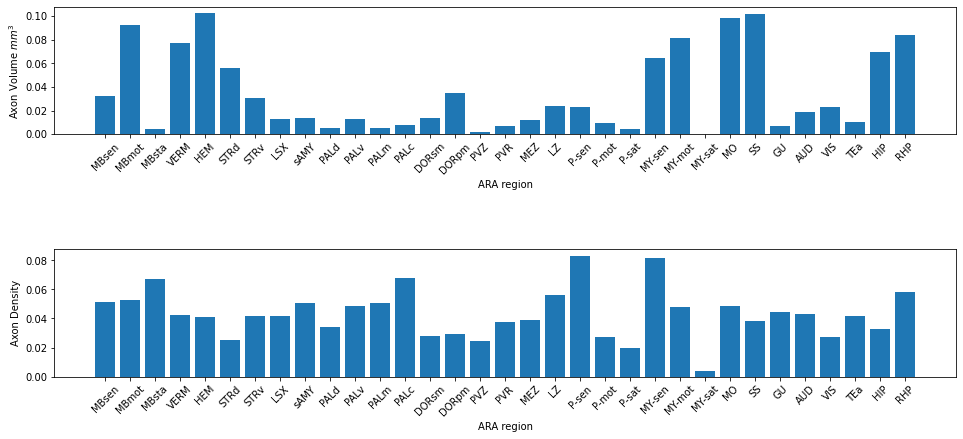

In [16]:
acros = []
densities = []
volumes = []

for node in G.nodes:
    if G.nodes[node]['st_level'] == 6 and G.nodes[node]['total_vol']>0:
        acros.append(G.nodes[node]['acronym'])
        volumes.append(G.nodes[node]['axon_vol'])
        densities.append(G.nodes[node]['axon_vol']/G.nodes[node]['total_vol'])

volumes = np.multiply(volumes, 6.7/(1000**3))
ax = plt.subplot(211)
ax.bar(acros,volumes)
ax.set_ylabel("Axon Volume $mm^3$")
ax.set_xlabel("ARA region")
plt.xticks(rotation=45)
ax = plt.subplot(212)
ax.bar(acros,densities)
ax.set_ylabel("Axon Density")
ax.set_xlabel("ARA region")
plt.xticks(rotation=45)
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(15, 7)
plt.show()

In [ ]:
thresh = 8*10**6

keys = []
values = []

for node in G.nodes:
    total_vol = G.nodes[node]['total_vol']
    if not total_vol > 0:
        continue

    for in_node in G.predecessors(node):
        if G.nodes[in_node]['total_vol'] < thresh:
            big_parent = False
        else:
            big_parent = True

    small_children = True
    for out_node in G.successors(node):
        if G.nodes[out_node]['total_vol'] > thresh:
            small_children = False

    if small_children and big_parent:
        name = G.nodes[node]['name']
        axon_vol = G.nodes[node]['axon_vol']
        keys.append(name)
        values.append(axon_vol/total_vol)


fig, ax = plt.subplots(figsize=(2,10))
df = pd.DataFrame({"Fraction of Voxels Classified as Axon": values}, index=keys)
idxs = np.argsort(values)
labels = ['' for i in values]
for i in range(np.amin([7, len(values)])):
    labels[idxs[-i]] = keys[idxs[-i]]
plot = sns.heatmap(ax=ax, data=df, fmt="g", cmap='viridis', annot_kws={"size": 50}, yticklabels=labels)
#plot.set_xticklabels(plot.get_xmajorticklabels(), fontsize = 18)
#plot.set_yticklabels(plot.get_ymajorticklabels(), fontsize = 18, rotation=45)
plt.title(f"{len(keys)} largest ROIs with Volume < {thresh:.2e} um^3")
plt.show()

    

# Brain 4

In [ ]:
dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_15_Sert_Cre_R/Ch_647"
mip = 0
vol_fg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_15_Sert_Cre_R/Ch_561"
vol_bg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_15_Sert_Cre_R/Ch_488"
vol_endo = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)
print(vol_endo.shape)

#dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/axon_mask"
#vol_mask = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

#dir = "precomputed://https://dlab-colm.neurodata.io/2021_07_01_Sert_Cre_B/atlas_to_target"
#vol_reg = CloudVolume(dir, parallel=1, mip=mip, fill_missing=True)

centers_train = []
centers_val = [[4781, 3581, 1861], [2982, 482, 1841], [2258, 6504, 1392], [2884, 2434, 1392], [1659, 4108, 1392], [3457, 5082, 1392], [2850, 5163, 3116]]

# Old

### Read swcs

In [ ]:
from brainlit.utils.Neuron_trace import NeuronTrace
from pathlib import Path
from scipy.ndimage import distance_transform_edt

In [ ]:
swc_path = Path("/Users/thomasathey/Documents/mimlab/mouselight/ailey/" + part + "_traces/")

swc_files = list(swc_path.glob("**/*.swc"))

paths_total = []
for swc_num, swc in enumerate(swc_files):

    swc_trace = NeuronTrace(path=str(swc))
    paths = swc_trace.get_paths()
    offset_diff, _, _, _ = swc_trace.get_df_arguments()

    for path_num, p in enumerate(paths):
        paths_total.append(p)

In [ ]:
swc_mask = 0*mask
for path in paths_total:
    path = path.astype(int)
    swc_mask[path[:,0], path[:,1], path[:,2]] = 1
    
edt = distance_transform_edt(swc_mask==0)
swc_mask[edt < 2] = 1

In [ ]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(np.swapaxes(image,0,2))
viewer.add_labels(np.swapaxes(mask,0,2))
#viewer.add_labels(swc_mask)
#viewer.add_shapes(data=paths_total, shape_type='path', edge_width=1.0, edge_color='blue', opacity=0.8)

In [ ]:
tpr = np.sum(np.logical_and(swc_mask, np.swapaxes(mask,0,2)))/np.sum(swc_mask)
fpr = np.sum(np.logical_and(swc_mask==0, np.swapaxes(mask==1,0,2)))/np.sum(swc_mask==0)
print(f"TPR: {tpr}, FPR: {fpr}")

# Make annotation layer

Making new annotation layer
-output data and x,y,z bounds

In [ ]:
vol_bg.volume_size

cannot write to https link, can write to s3 link

In [ ]:

dir = "s3://smartspim-precomputed-volumes/2021_07_01_Sert_Cre_B/axon_mask"

info = CloudVolume.create_new_info(
    num_channels    = 1,
    layer_type      = 'segmentation',
    data_type       = 'uint64', # Channel images might be 'uint8'
    encoding        = 'raw', # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution      = vol_bg.resolution, # Voxel scaling, units are in nanometers
    voxel_offset    = vol_bg.voxel_offset, # x,y,z offset in voxels from the origin
    # mesh            = 'mesh',
    # Pick a convenient size for your underlying chunk representation
    # Powers of two are recommended, doesn't need to cover image exactly
    chunk_size      = [ 128, 128, 2 ], # units are voxels
    volume_size     = vol_bg.volume_size, # e.g. a cubic millimeter dataset
)
vol_mask = CloudVolume(dir, info=info)
vol_mask.commit_info()

In [ ]:
vol_mask.volume_size

In [ ]:

image_fg = vol_fg[2432:2560, 3584:3712, 2400:2440]
image_bg = vol_bg[2432:2560, 3584:3712, 2400:2440]
image_2channel = np.stack([image_bg, image_fg], axis=0)
fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/example_annotation/example.h5"
with h5py.File(fname, "w") as f:
    dset = f.create_dataset("image_2channel", data=image_2channel)

In [ ]:
example = "off_2"

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/example_annotation/example.h5"
f = h5py.File(fname, 'r')
im = f.get('image_2channel')
im_fg = im[1,:,:,:,0]

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/example_annotation/example_Probabilities_3d_2channel.h5"
f = h5py.File(fname, 'r')
pred = f.get('exported_data')
pred = pred[1,:,:,:,0]
mask = pred > 0.5
try:
    mask = removeSmallCCs(mask, 100)
except ValueError:
    mask = 0*im_fg

print(im_fg.shape == mask.shape)

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(im_fg)
viewer.add_labels(mask)
napari.run()

In [ ]:
vol_mask[2432:2560, 3584:3712, 2400:2440, 0] = mask.astype('uint64')

In [ ]:
mask2 = vol_mask[2432:2560, 3584:3712, 2400:2440, 0]
mask2.shape

In [ ]:
mask.shape

https://viz.neurodata.io/?json_url=https://json.neurodata.io/v1?NGStateID=E-917tNc_GylnQ

## Brainlit example

In [ ]:
dir = "s3://open-neurodata/brainlit/brain2/axons"

info = CloudVolume.create_new_info(
    num_channels    = 1,
    layer_type      = 'segmentation',
    data_type       = 'uint64', # Channel images might be 'uint8'
    encoding        = 'raw', # raw, jpeg, compressed_segmentation, fpzip, kempressed
    resolution      = vol_brainlit.resolution, # Voxel scaling, units are in nanometers
    voxel_offset    = vol_brainlit.voxel_offset, # x,y,z offset in voxels from the origin
    # mesh            = 'mesh',
    # Pick a convenient size for your underlying chunk representation
    # Powers of two are recommended, doesn't need to cover image exactly
    chunk_size      = [ 68, 52, 80 ], # units are voxels
    volume_size     = vol_brainlit.volume_size, # e.g. a cubic millimeter dataset
)
vol = CloudVolume(dir, info=info)
vol.commit_info()

In [ ]:
import numpy as np 

In [ ]:
a = np.zeros((68,52,80), dtype='uint64')
a[30:35,:,:] = 1
vol[:68,:52,:80] = a

# Second sample

In [ ]:
dir = "precomputed://https://dlab-colm.neurodata.io/2021_06_02_Sert_Cre/Ch_647"

vol_fg = CloudVolume(dir)

## Download and save samples

In [ ]:
pos_centers = [[3071, 765, 2342], [5065, 3455, 2342], [3262, 7854, 2342]] #tectum, cortex, olfactory bulb
neg_centers = [[3557, 4797, 2342], [1564, 1997, 2342], [1606, 5204, 2342]] #?, edge of brain/tectum, white matter
radius = 100

for i, center in enumerate(pos_centers):
    image_fg = vol_fg[center[0]-radius:center[0]+radius, center[1]-radius:center[1]+radius, center[2]-radius:center[2]+radius]
    image_bg = 0*image_fg
    image_2channel = np.stack([image_bg, image_fg], axis=0)
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/brain2_data/images/on_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)


for i, center in enumerate(neg_centers):
    image_fg = vol_fg[center[0]-radius:center[0]+radius, center[1]-radius:center[1]+radius, center[2]-radius:center[2]+radius]
    image_bg = 0*image_fg
    image_2channel = np.stack([image_bg, image_fg], axis=0)
    fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/brain2_data/images/off_" + str(i) + ".h5"
    with h5py.File(fname, "w") as f:
        dset = f.create_dataset("image_2channel", data=image_2channel)

## Read ilastik results

In [ ]:
example = "off_2"

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/brain2_data/images/" + example + ".h5"
f = h5py.File(fname, 'r')
im = f.get('image_2channel')
im_fg = im[1,:,:,:,0]

fname = "/Users/thomasathey/Documents/mimlab/mouselight/ailey/brain2_data/images/" + example + "_Probabilities_3d_2channel.h5"
f = h5py.File(fname, 'r')
pred = f.get('exported_data')
pred = pred[1,:,:,:,0]
mask = pred > 0.5

try:
    mask = removeSmallCCs(mask, 100)
except ValueError:
    mask = 0*im_fg

print(im_fg.shape == mask.shape)

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(im_fg)
viewer.add_labels(mask)
napari.run()

brain 1

In [ ]:
from brainlit.utils import NeuroglancerSession

In [ ]:
vol_im1 = CloudVolume('https://open-neurodata.s3.amazonaws.com/brainlit/brain1', parallel=1, mip=0, fill_missing=True)
vol_skel1 = CloudVolume('precomputed://https://open-neurodata.s3.amazonaws.com/brainlit/brain1_segments')
skel2 = vol_skel1.skeleton.get(11)
skel2.vertices
#session = NeuroglancerSession("s3://open-neurodata/brainlit/brain1", 0)

In [ ]:
coord = skel2.vertices[0,:]
coord = np.divide(coord, vol_im1.resolution)

In [ ]:
coord = [19796.43356643, 14046.11235955,  5254.32142857]
coord = [int(c) for c in coord]
image = vol_im1[coord[0]-50:coord[0]+50, coord[1]-50:coord[1]+50, coord[2]-50:coord[2]+50]
image = np.squeeze(image)
image.shape

In [ ]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image)
napari.run()